# Plants RAG based LLM Model:

This RAG based LLM model can help you to find answers to your questions about plants.

## What is RAG?

RAG stands for Retrieval Augmented Generation. The goal of RAG is retrieve some data about the user question from a source and pass it to the LLM model. Then LLM model can take this data and use it to answer user's question.

RAG has 3 main parts:
1. Retrieval : Find relevant information about the question.

2. Augmented : Take this relevant information and augment it to the LLM model.

3. Generation : Take the first two steps and pass them to an LLM for generate outputs.

## Coding Part:

### Import PDF Document:

In [5]:
pdf_file_path = "plants.pdf" # PDF file path

In [6]:
!pip install -q PyMuPDF # A library to work with PDF files
import fitz
from tqdm.auto import tqdm # A library to visualize the process

In [7]:
def read_pdf(pdf_file_path: str) -> list[dict]:
  """
  A function to open and read pdf and create a list of dictionary for each page.
  """
  pdf_doc = fitz.open(pdf_file_path)
  pages_and_texts = []

  for page_number, page in tqdm(enumerate(pdf_doc)):
    text = page.get_text()
    text = text_formatter(text = text)
    pages_and_texts.append({"page_number": page_number - 7,
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count": len(text.split(". ")),
                            "page_token_count": len(text) / 4,
                            "text": text})

  return pages_and_texts

def text_formatter(text: str) -> str:
  """
  A function to perform formatting on text.
  """
  cleaned_text = text.replace("\n", " ").strip()

  return cleaned_text

In [8]:
pages_and_texts = read_pdf(pdf_file_path = pdf_file_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -7,
  'page_char_count': 67,
  'page_word_count': 11,
  'page_sentence_count': 2,
  'page_token_count': 16.75,
  'text': 'Created by XMLmind XSL-FO Converter.  PLANT PHYSIOLOGY  Vince Ördög'},
 {'page_number': -6,
  'page_char_count': 90,
  'page_word_count': 15,
  'page_sentence_count': 2,
  'page_token_count': 22.5,
  'text': 'Created by XMLmind XSL-FO Converter.  PLANT PHYSIOLOGY  Vince Ördög  Publication date 2011'}]

In [9]:
# Let's have a look at random examples
import random

random.sample(pages_and_texts, 2)

[{'page_number': 96,
  'page_char_count': 2519,
  'page_word_count': 440,
  'page_sentence_count': 17,
  'page_token_count': 629.75,
  'text': 'Physiology of plant growth and  development      98    Created by XMLmind XSL-FO Converter.    Figure 3.25 Auxin promotes fruit development that produced by achenes (source: Taiz L., Zeiger E., 2010)  Commercial use of gibberellins  The major uses of gibberellins (GA3), applied as a spray or dip, are to manage fruit crops, to malt barley, and to  increase sugar yield in sugarcane. In some crops a reduction in height is desirable, and this can be accomplished  by the use of gibberellin synthesis inhibitors.  Many of the table grapes grown in the United States are a genetically seedless variety that would naturally  produce small fruit on very compact clusters. Almost all seedless grapes on the market are treated with GA3. It  substitutes for the presence of seeds, which would normally be the source of native GAs for fruit growth.  Repeated spray

In [10]:
# Convert it into a pandas DataFrame
import pandas as pd

pages_and_texts_df = pd.DataFrame(pages_and_texts)
pages_and_texts_df.head()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
0,-7,67,11,2,16.75,Created by XMLmind XSL-FO Converter. PLANT PH...
1,-6,90,15,2,22.50,Created by XMLmind XSL-FO Converter. PLANT PH...
2,-5,5544,422,85,1386.00,iii Created by XMLmind XSL-FO Converter. T...
3,-4,220,20,4,55.00,iv Created by XMLmind XSL-FO Converter. Li...
4,-3,198,34,2,49.50,v Created by XMLmind XSL-FO Converter. Cov...


In [11]:
pages_and_texts_df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,121.000000,121.000000,121.000000,121.000000,121.000000
mean,53.000000,3451.917355,559.264463,25.305785,862.979339
std,35.073732,1291.526084,206.106921,11.070112,322.881521
min,-7.000000,0.000000,1.000000,1.000000,0.000000
25%,23.000000,3060.000000,495.000000,20.000000,765.000000
50%,53.000000,3462.000000,577.000000,25.000000,865.500000
75%,83.000000,4338.000000,703.000000,32.000000,1084.500000
max,113.000000,5578.000000,914.000000,85.000000,1394.500000


### Splitting Pages Into Sentences:

In [12]:
# We need an NLP library such as spaCy and nltk
!pip install -q spaCy

In [13]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# An instance
doc = nlp("I like programming various types of artificial intelligence models. I study at Ankara University. I like cats.")
assert len(list(doc.sents)) == 3

# Print out our senteces split
list(doc.sents)

[I like programming various types of artificial intelligence models.,
 I study at Ankara University.,
 I like cats.]

In [14]:
# Let's apply it to one of our pages
page_and_text = pages_and_texts[100]
page_and_text

{'page_number': 93,
 'page_char_count': 1942,
 'page_word_count': 307,
 'page_sentence_count': 13,
 'page_token_count': 485.5,
 'text': 'Physiology of plant growth and  development      95    Created by XMLmind XSL-FO Converter.    Figure 3.23 Changes in water potential, stomatal resistance, and ABA content in corn in response to water  stress (source: Taiz L., Zeiger E., 2010)  3.8. Brassinosteroids  Brassinosteroids (BRs) are steroid hormones with a chemical structure similar to the steroid hormones in  animals. Brassinosteroids elicit an impressive array of developmental responses, including an increased rate of  stem and pollen tube elongation, increased rates of cell division (in the presence of auxin and cytokinin), seed  germination, leaf morphogenesis, apical dominance, inhibition of root elongation, vascular differentiation,  accelerated senescence, and cell death. Brassinosteroids are also implicated in mediating responses to both  abiotic and biotic stress, including salt, d

In [15]:
sentences = nlp(page_and_text["text"])
assert len(list(sentences.sents)) <= 13
list(sentences.sents)

[Physiology of plant growth and  development      95    Created by XMLmind XSL-FO Converter.,
    Figure 3.23 Changes in water potential, stomatal resistance, and ABA content in corn in response to water  stress (source: Taiz L., Zeiger E., 2010)  3.8.,
 Brassinosteroids  Brassinosteroids (BRs) are steroid hormones with a chemical structure similar to the steroid hormones in  animals.,
 Brassinosteroids elicit an impressive array of developmental responses, including an increased rate of  stem and pollen tube elongation, increased rates of cell division (in the presence of auxin and cytokinin), seed  germination, leaf morphogenesis, apical dominance, inhibition of root elongation, vascular differentiation,  accelerated senescence, and cell death.,
 Brassinosteroids are also implicated in mediating responses to both  abiotic and biotic stress, including salt, drought, temperature extremes, and pathogens.,
  BRs cause dramatic changes in growth and differentiation at very low concentrati

In [16]:
# Let's apply it to the all pages
for item in tqdm(pages_and_texts):
  # Create a key 'sentences'
  item["sentences"] = list(nlp(item["text"]).sents)

  # Make sure that all sentences are string
  item["sentences"] = [str(sentence) for sentence in item['sentences']]

  # Sentence count by spaCy
  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/121 [00:00<?, ?it/s]

In [17]:
# Let's have a look at an example
random.sample(pages_and_texts, k=1)

[{'page_number': 19,
  'page_char_count': 3207,
  'page_word_count': 531,
  'page_sentence_count': 24,
  'page_token_count': 801.75,
  'text': 'Water and nutrients in plant      21    Created by XMLmind XSL-FO Converter.  system by the application of cellular energy. One common way (but not the only way) of accomplishing this  task is to couple transport to the hydrolysis of ATP.  The chemical potential for any solute is defined as the sum of the concentration, electric, and hydrostatic  potentials (and the chemical potential under standard conditions). The importance of the concept of chemical  potential is that it sums all the forces that may act on a molecule to drive net transport. In general, diffusion  (passive transport) always moves molecules energetically downhill from areas of higher chemical potential to  areas of lower chemical potential. Movement against a chemical-potential gradient is indicative of active  transport (Figure 1.17). If we take the diffusion of sucrose acro

In [18]:
# Let's convert them into a Pandas DataFrame
pages_and_texts_df = pd.DataFrame(pages_and_texts)
pages_and_texts_df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,121.00,121.00,121.00,121.00,121.00,121.00
mean,53.00,3451.92,559.26,25.31,862.98,24.98
std,35.07,1291.53,206.11,11.07,322.88,9.71
min,-7.00,0.00,1.00,1.00,0.00,0.00
25%,23.00,3060.00,495.00,20.00,765.00,21.00
50%,53.00,3462.00,577.00,25.00,865.50,25.00
75%,83.00,4338.00,703.00,32.00,1084.50,32.00
max,113.00,5578.00,914.00,85.00,1394.50,49.00


### Chunking our sentences together:

We'll split into groups of 10 sentences.

In [19]:
# Define split size to turn groups of sentences into chunks

num_sentence_size = 10

def split_list(input_list: list,
               slice_size: int = num_sentence_size) -> list[list[str]]:
  """
  A function to split a list into pieces
  """
  return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

In [20]:
# Let's try it
test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [21]:
# Loop through pages and texts and split sentences into groups

for item in tqdm(pages_and_texts):
  item["sentence_group"] = split_list(input_list = item["sentences"],
                                       slice_size = num_sentence_size)
  item["num_groups"] = len(item['sentence_group'])

  0%|          | 0/121 [00:00<?, ?it/s]

In [22]:
# Let's have a look at an example

random.sample(pages_and_texts, k = 1)

[{'page_number': 112,
  'page_char_count': 2347,
  'page_word_count': 411,
  'page_sentence_count': 13,
  'page_token_count': 586.75,
  'text': "114    Created by XMLmind XSL-FO Converter.  Chapter 6. Questions  What is the importance of water in a plant's life?  What kind of driving forces are involved in water movement?  What are the components of plant water potential?  How plant water potential can be measured?  What is the role of root hairs in water uptake?  How the water is absorbed and moved from soil to plant's canopy?  What transpiration types exist in plant kingdom?  What are the main characteristics of plant water status?  A decrease or cessation of leaf expansion is an early response to water stress. Provide a mechanism for this  response.  Explain the role of the stomatal response to abscisic acid in plant tolerance to water stress.  What does a plant need to grow from seed and complete its life cycle?  What is an essential element? How many have been identified?  What is

In [23]:
# Let's convert out pages_and_texts list into a dataframe
pages_and_texts_df = pd.DataFrame(pages_and_texts)
pages_and_texts_df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_groups
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,53.00,3451.92,559.26,25.31,862.98,24.98,3.01
std,35.07,1291.53,206.11,11.07,322.88,9.71,0.98
min,-7.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,23.00,3060.00,495.00,20.00,765.00,21.00,3.00
50%,53.00,3462.00,577.00,25.00,865.50,25.00,3.00
75%,83.00,4338.00,703.00,32.00,1084.50,32.00,4.00
max,113.00,5578.00,914.00,85.00,1394.50,49.00,5.00


### Splitting each group into its own item:

In [24]:
import re

# Split each group into its own item
pages_and_groups = []

for item in tqdm(pages_and_texts):
  for sentence_group in item['sentence_group']:
    group_dict = {}
    group_dict['page_number'] = item['page_number']

    # Join sentences together into a paragraph like structure, aka join the list of sentences into one paragraph
    joined_sentence_group = "".join(sentence_group).replace("  ", " ").strip()
    joined_sentence_group = re.sub(r"\.([A-Z])", r'. \1', joined_sentence_group) # .A -> . A

    group_dict["sentence_group"] = joined_sentence_group

    # Get some stats on our group
    group_dict["group_char_count"] = len(joined_sentence_group)
    group_dict["group_word_count"] = len([word for word in joined_sentence_group.split(" ")])
    group_dict["group_token_count"] = len(joined_sentence_group) / 4 # 1 token = 4 chats

    pages_and_groups.append(group_dict)

print("Number of pages and groups: ",len(pages_and_groups))

  0%|          | 0/121 [00:00<?, ?it/s]

Number of pages and groups:  364


In [25]:
# Let's have a look at an example
random.sample(pages_and_groups, k = 1)

[{'page_number': 100,
  'sentence_group': 'Physiology of plant growth and development   102  Created by XMLmind XSL-FO Converter. building, the number and size of tubers, which resulted in yield increase. At one of the trial sites in county Csongrád the strain MACC-612 showed a definite and well recognisable fungicide side effect in potatoes. We were able to influence the competition between beetroot and the foliage of sugar beet significantly and as a result of a longer active foliage life we could avoid harmful change of leaves even in climatic stress situations. With this successful treatment sugar beet yield per area unit increased and although the sugar content in percentage slightly decreased the absolute sugar yield increased as well (Figure 3.29). We applied microalgae in potato trials alone but they were applied as combination partners of fungicides in sugar beet. As a result the strains MACC-116 and MACC-612 can especially well be combined with strobilurin preparations.  Figu

In [26]:
# Let's create our DataFrame again
pages_and_groups_df = pd.DataFrame(pages_and_groups)
pages_and_groups_df.describe().round(2)

,page_number,group_char_count,group_word_count,group_token_count
count,364.00,364.00,364.00,364.00
mean,54.80,1133.22,172.32,283.30
std,34.51,467.41,72.62,116.85
min,-7.00,12.00,2.00,3.00
25%,24.00,870.75,124.00,217.69
50%,55.00,1258.00,192.00,314.50
75%,85.00,1448.00,222.00,362.00
max,113.00,2248.00,335.00,562.00


### Filter groups of text for short chunks:

In [27]:
# Show random groups with under 30 tokens in length
min_token_length = 30
for row in pages_and_groups_df[pages_and_groups_df['group_token_count'] <= min_token_length].sample(5).iterrows():
  print(f'Group token count: {row[1]["group_token_count"]} | Text: {row[1]["sentence_group"]}')

Group token count: 18.0 | Text: Leaf orientation may also change in response to low oxygen availability.
Group token count: 21.75 | Text: Created by XMLmind XSL-FO Converter. PLANT PHYSIOLOGY Vince Ördög Publication date 2011
Group token count: 14.75 | Text: Regeneration of the CO2 acceptor ribulose 1,5-bisphosphate.
Group token count: 3.0 | Text: When applied
Group token count: 16.25 | Text: Created by XMLmind XSL-FO Converter. PLANT PHYSIOLOGY Vince Ördög


They usually don't contain much useful information.

In [28]:
# Filter our DataFrame also
pages_and_groups_over_min_token_len = pages_and_groups_df[pages_and_groups_df['group_token_count'] > min_token_length].to_dict(orient = "records")
random.sample(pages_and_groups_over_min_token_len, k=2)

[{'page_number': 21,
  'sentence_group': 'Membrane proteins that carry out primary active transport are called pumps. Most pumps transport ions, such as H+ or Ca2+. However, pumps belonging to the ATP-binding cassette (ABC) family of transporters can carry large organic molecules. For the plasma membranes of plants, fungi, and bacteria, as well as for plant tonoplasts and other plant and animal endomembranes, H+ is the principal ion that is electrogenically pumped across the membrane. The plasma membrane H+-ATPase generates the gradient of electrochemical potential of H+ across the plasma membrane, while the vacuolar H+-ATPase and the H+- pyrophosphatase (H+-PPase) electrogenically pump protons into the lumen of the vacuole and the Golgi cisternae.',
  'group_char_count': 716,
  'group_word_count': 107,
  'group_token_count': 179.0},
 {'page_number': 25,
  'sentence_group': '• The macromolecule must be able to leave the sieve element-companion cell complex in sink tissues. Alternativel

### Embedding Our Text Groups:

Embedding is turning our text groups into numbers which a machine can understand.

```
{
  "the": 0,
  "a": 1,
  ...
}
```

In [29]:
!pip install -q sentence_transformers
from sentence_transformers import SentenceTransformer # A library to help us to embed our text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.5 MB/s eta 0:00:00


In [30]:
# Create our embedding model
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2", device = "cpu")

# Create a list of sentences
sentences = ["The Sentence Transformer Library provides an easy way to create embeddings", "Sentences can be embedded one by one or in a list", "I like cats!"]

# Sentences are embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
  print(f"Sentence = {sentence}")
  print(f"Embedding = {embedding}")
  print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence = The Sentence Transformer Library provides an easy way to create embeddings
Embedding = [-3.17512117e-02  3.37267816e-02 -2.52437890e-02  5.22287451e-02
 -2.35249270e-02 -6.19112747e-03  1.35026323e-02 -6.25501126e-02
  7.50829605e-03 -2.29684319e-02  2.98147108e-02  4.57554646e-02
 -3.26700062e-02  1.39847314e-02  4.18014154e-02 -5.92969693e-02
  4.26309668e-02  5.04656276e-03 -2.44552474e-02  3.98593908e-03
  3.55897658e-02  2.78742518e-02  1.84098687e-02  3.67700309e-02
 -2.29961313e-02 -3.01797222e-02  5.99575753e-04 -3.64504047e-02
  5.69104515e-02 -7.49938749e-03 -3.70003618e-02 -3.04356636e-03
  4.64354530e-02  2.36149714e-03  9.06850232e-07  7.00033456e-03
 -3.92289571e-02 -5.95696410e-03  1.38653386e-02  1.87106989e-03
  5.34202717e-02 -6.18613102e-02  2.19613481e-02  4.86050621e-02
 -4.25697565e-02 -1.69858951e-02  5.04178070e-02  1.54733760e-02
  8.12859312e-02  5.07106259e-02 -2.27497071e-02 -4.35721055e-02
 -2.18391977e-03 -2.14091670e-02 -2.01757718e-02  3.06832

In [31]:
# Let's check the shape of embeddings
embeddings.shape

(3, 768)

In [32]:
# Let's move our model to GPU and apply embeddings to whole data
%%time

embedding_model.to("cuda")

for item in tqdm(pages_and_groups_over_min_token_len):
  item["embedding"] = embedding_model.encode(item["sentence_group"])

  0%|          | 0/357 [00:00<?, ?it/s]

CPU times: user 10 s, sys: 254 ms, total: 10.3 s
Wall time: 16.5 s


In [33]:
# Let's create a list that holds sentence groups
%%time

text_groups = [item["sentence_group"] for item in pages_and_groups_over_min_token_len]
print(f"Number of text groups : {len(text_groups)}")
random.sample(text_groups, k=1)

Number of text groups : 357
CPU times: user 940 µs, sys: 0 ns, total: 940 µs
Wall time: 953 µs


['Water and nutrients in plant   13  Created by XMLmind XSL-FO Converter. are severely damaged by 24 hours of anoxia (lack of oxygen). The yield of flooding-sensitive garden-pea (Pisum sativum) may decrease by fifty percent. Corn is affected by flooding in a milder way, and is more resistant to flooding. It can withstand anoxia temporarily, but not for periods of more than a few days. Soil anoxia damage plant roots directly by inhibiting cellular respiration. The critical oxygen pressure (COP) is the oxygen pressure below which respiration rates decrease as a result of O2 deficiency. The COP for the corn root tip growing in a well-stirred nutrient solution at 25°C is about 20 kilopascals (kPa), or 20% O2 by volume, close to the oxygen concentration in ambient air. 2. Nutrient supply of plant Unlike heterotrophic organisms, which depend for their existence on energy-rich organic molecules previously synthesized by other organisms, plants must survive in an entirely inorganic environment

In [34]:
# Embed all texts in batches and convert them into torch.Tensor
%%time

text_group_embeddings = embedding_model.encode(text_groups,
                                               batch_size = 32,
                                               convert_to_tensor = True)

text_group_embeddings

CPU times: user 4.05 s, sys: 31.4 ms, total: 4.08 s
Wall time: 7.02 s


tensor([[-0.0062, -0.1053,  0.0040,  ...,  0.0081, -0.0133,  0.0096],
        [-0.0217, -0.0676,  0.0062,  ..., -0.0096, -0.0186, -0.0209],
        [-0.0411, -0.0708,  0.0192,  ...,  0.0227, -0.0342, -0.0191],
        ...,
        [-0.0414, -0.0250,  0.0100,  ...,  0.0117, -0.0108, -0.0107],
        [-0.0621, -0.0217, -0.0031,  ...,  0.0312, -0.0161, -0.0491],
        [-0.0505, -0.1102, -0.0067,  ..., -0.0091,  0.0107, -0.0058]],
       device='cuda:0')

### Save embeddings to file:

In [35]:
text_groups_and_embeddings_df = pd.DataFrame(pages_and_groups_over_min_token_len)
embeddings_save_path = "text_groups_and_embeddings_df.csv"
text_groups_and_embeddings_df.to_csv(embeddings_save_path, index = False)

### Import saved embeddings and view:

In [36]:
text_groups_and_embeddings_df_loaded = pd.read_csv(embeddings_save_path)
text_groups_and_embeddings_df_loaded.sample(3)

,page_number,sentence_group,group_char_count,group_word_count,group_token_count,embedding
196,62,Physiology of plant growth and development 6...,1733,280,433.25,[-2.42947731e-02 -1.27261495e-02 2.34322529e-...
300,95,4. Synthetic and microbial plant hormones in p...,1305,198,326.25,[-3.80503163e-02 -1.08105643e-02 1.19205192e-...
198,62,2. Overview of plant growth and development Th...,1174,181,293.50,[-2.14929376e-02 -3.63488533e-02 -8.26298259e-...


### RAG - Search and Answer:

#### Similarity Search:

In [37]:
# import libaries
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embeddings df
text_groups_and_embeddings_df = pd.read_csv("text_groups_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to str when it saved to csv)
text_groups_and_embeddings_df["embedding"] = text_groups_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep = "  "))

# Convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_groups_and_embeddings_df["embedding"].tolist(), axis = 0), dtype = torch.float32).to(device)

# Conver texts and embedding df to list of dicts
pages_and_groups = text_groups_and_embeddings_df.to_dict(orient = "records")

text_groups_and_embeddings_df.sample(3)

,page_number,sentence_group,group_char_count,group_word_count,group_token_count,embedding
265,84,Physiology of plant growth and development 8...,1462,223,365.5,"[-0.0664153025, -0.0397088826, 0.0242087021, 0..."
317,101,The inhibition of gibberellin biosynthesis als...,1232,173,308.0,"[-0.0200249478, -0.0247363988, 0.0160212871, 0..."
219,68,In order to function efficiently as a conduit ...,928,151,232.0,"[-0.0688219368, -0.0827836916, 0.00846744888, ..."


In [38]:
embeddings.shape

torch.Size([357, 768])

In [39]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2", device = device)

In [40]:
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [41]:
# 1. Define a query
query = "brassinosteroids and their effects"
print(f"Query : {query}")

# 2. Embed the query
query_embedding = embedding_model.encode(query, convert_to_tensor = True).to(device)

# 3. Get similarity scores with the dot product (use cosine similarty if outputs of the model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

# 4. Get the top k results
top_results_dot_product = torch.topk(dot_scores, k = 5)
top_results_dot_product

Query : brassinosteroids and their effects
[INFO] Time taken to get scores on 357 embeddings: 0.00314 seconds.


torch.return_types.topk(
values=tensor([0.7192, 0.6609, 0.5976, 0.5635, 0.5630], device='cuda:0'),
indices=tensor([293, 292, 309, 294, 319], device='cuda:0'))

In [42]:
pages_and_groups[309]

{'page_number': 98,
 'sentence_group': 'Ethephon is sprayed in aqueous solution and is readily absorbed and transported within the plant. It releases ethylene slowly by a chemical reaction, allowing the hormone to exert its effects. It is used for: • hastening fruit ripening of apple, tomato, and degreening of citrus; • synchronized flowering and fruit set in pineapple, and accelerated abscission of flowers and fruits; • inducing fruit thinning or fruit drop in cotton, cherry, and walnut; • promoting female sex expression in cucumber, to prevent self-pollination and increase yield; • inhibition of terminal growth of some plants in order to promote lateral growth and compact flowering stems. Brassinosteroid (BR) application to crop plants is most effective under stress conditions Brassinosteroids were discovered as a class of growth promoting hormones, and researchers immediately recognized their potential applications to agriculture. For the past 20 years, numerous small-scale studies 

In [43]:
# Let's create a function to visualize results better
import textwrap

def print_wrapped(text, wrap_length = 80):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

In [44]:
query = "brassinosteroids and their effects"
print(f"Query: '{query}'\n")
print(f"Results :")

# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
  print(f"Score : {score:.4f}")
  print("Text: ")
  print_wrapped(pages_and_groups[idx]["sentence_group"])
  print(f'Page Number : {pages_and_groups[idx]["page_number"]}')
  print("\n")

Query: 'brassinosteroids and their effects'

Results :
Score : 0.7192
Text: 
Figure 3.24 Bean second-internode bioassay for brassinosteroids (source: Taiz
L., Zeiger E., 2010) Brassinosteroids are synthesized from campesterol
Page Number : 93


Score : 0.6609
Text: 
Physiology of plant growth and development   95  Created by XMLmind XSL-FO
Converter.  Figure 3.23 Changes in water potential, stomatal resistance, and ABA
content in corn in response to water stress (source: Taiz L., Zeiger E., 2010)
3.8. Brassinosteroids Brassinosteroids (BRs) are steroid hormones with a
chemical structure similar to the steroid hormones in animals. Brassinosteroids
elicit an impressive array of developmental responses, including an increased
rate of stem and pollen tube elongation, increased rates of cell division (in
the presence of auxin and cytokinin), seed germination, leaf morphogenesis,
apical dominance, inhibition of root elongation, vascular differentiation,
accelerated senescence, and cell death

#### Using FAISS Vector Database:

In [45]:
!pip install faiss-gpu
# Import necessary libraries and data
import faiss

# Creating global variables
VECTOR_DIM = embeddings.shape[1]

# A function to move embeddings from GPU to CPU
def to_cpu(embeddings):
    embedding_vectors = embeddings.cpu().numpy()
    return embedding_vectors

# A function to create a FAISS index
def create_faiss_index(embedding_vectors, vector_dimension):
    index = faiss.IndexFlatL2(vector_dimension)
    index.add(embedding_vectors)
    print(f"Total number of vectors in the index is {index.ntotal}")

    return index

embedding_vectors = to_cpu(embeddings)
index = create_faiss_index(embedding_vectors, VECTOR_DIM)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.3 MB/s eta 0:00:00
Total number of vectors in the index is 357


### Retrieve Data:

In [46]:
def retrieve_relevant_resources(query: str,
                                embeddings: np.ndarray = embeddings,
                                model: SentenceTransformer = embedding_model,
                                n_resources_to_return: int = 5,
                                print_time: bool = True,
                                use_faiss: bool = False):
  """
  Embeds a query with model and returns top k scores and indices from embeddings. This function can both use util.dot_score() and faiss database to retrieve data.
  """

  if use_faiss:
    VECTOR_DIM = embeddings.shape[1]

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True).cpu().numpy().astype('float32')

    # Create the index
    index = create_faiss_index(embedding_vectors,
                               vector_dimension = VECTOR_DIM)

    # Reshape if necessary to ensure 2D array
    if len(query_embedding.shape) == 1:
      query_embedding = query_embedding.reshape(1, -1)

    # Get the distances and time it
    start_time = timer()
    distances, indices = index.search(query_embedding, k = n_resources_to_return)
    end_time = timer()

    if print_time:
      print(f"[INFO] Time taken to get distances on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

    return distances, indices

  # Embed the query
  query_embedding = model.encode(query, convert_to_tensor = True)

  # Get dot product scores on embeddings
  start_time = timer()
  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time = timer()

  if print_time:
    print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

  scores, indices = torch.topk(input = dot_scores,
                               k = n_resources_to_return)

  return scores, indices

In [47]:
def print_top_results(query: str,
                      embeddings: torch.tensor,
                      pages_and_groups: list[dict] = pages_and_groups,
                      n_resources_to_return: int = 5,
                      use_faiss: bool = False):
  """
  Finds relevant resources given a query and prints them out along with their scores of distances whether used faiss or not.
  """
  if use_faiss:
    distances, indices = retrieve_relevant_resources(query = query,
                                                     embeddings = embeddings,
                                                     model = embedding_model,
                                                     n_resources_to_return = 5,
                                                     use_faiss = True)

    # Loop through zipped together scores and indices
    for distance, idx in zip(distances[0], indices[0]):
      print(f"Distance : {distance:.4f}")
      print("Text: ")
      print_wrapped(pages_and_groups[idx]["sentence_group"])
      print(f'Page Number : {pages_and_groups[idx]["page_number"]}')
      print("\n")

  else:
    scores, indices = retrieve_relevant_resources(query = query,
                                                     embeddings = embeddings,
                                                     model = embedding_model,
                                                     n_resources_to_return = 5,
                                                     use_faiss = False)

    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
      print(f"Score : {score:.4f}")
      print("Text: ")
      print_wrapped(pages_and_groups[idx]["sentence_group"])
      print(f'Page Number : {pages_and_groups[idx]["page_number"]}')
      print("\n")

In [73]:
# Let's try our functions
query = "brassinosteroids and their effects"

# util.dot_score() search
print_top_results(query = query,
                  embeddings = embeddings,
                  pages_and_groups = pages_and_groups,
                  n_resources_to_return = 5,
                  use_faiss = False)

[INFO] Time taken to get scores on 357 embeddings: 0.00007 seconds.
Score : 0.7192
Text: 
Figure 3.24 Bean second-internode bioassay for brassinosteroids (source: Taiz
L., Zeiger E., 2010) Brassinosteroids are synthesized from campesterol
Page Number : 93


Score : 0.6609
Text: 
Physiology of plant growth and development   95  Created by XMLmind XSL-FO
Converter.  Figure 3.23 Changes in water potential, stomatal resistance, and ABA
content in corn in response to water stress (source: Taiz L., Zeiger E., 2010)
3.8. Brassinosteroids Brassinosteroids (BRs) are steroid hormones with a
chemical structure similar to the steroid hormones in animals. Brassinosteroids
elicit an impressive array of developmental responses, including an increased
rate of stem and pollen tube elongation, increased rates of cell division (in
the presence of auxin and cytokinin), seed germination, leaf morphogenesis,
apical dominance, inhibition of root elongation, vascular differentiation,
accelerated senescence, a

In [74]:
# FAISS Vector Database search
print_top_results(query = query,
                  embeddings = embeddings,
                  pages_and_groups = pages_and_groups,
                  n_resources_to_return = 5,
                  use_faiss = True)

Total number of vectors in the index is 357
[INFO] Time taken to get distances on 357 embeddings: 0.00074 seconds.
Distance : 0.5616
Text: 
Figure 3.24 Bean second-internode bioassay for brassinosteroids (source: Taiz
L., Zeiger E., 2010) Brassinosteroids are synthesized from campesterol
Page Number : 93


Distance : 0.6783
Text: 
Physiology of plant growth and development   95  Created by XMLmind XSL-FO
Converter.  Figure 3.23 Changes in water potential, stomatal resistance, and ABA
content in corn in response to water stress (source: Taiz L., Zeiger E., 2010)
3.8. Brassinosteroids Brassinosteroids (BRs) are steroid hormones with a
chemical structure similar to the steroid hormones in animals. Brassinosteroids
elicit an impressive array of developmental responses, including an increased
rate of stem and pollen tube elongation, increased rates of cell division (in
the presence of auxin and cytokinin), seed germination, leaf morphogenesis,
apical dominance, inhibition of root elongation

We got the same results.

In [116]:
import fitz
import matplotlib.pyplot as plt

pdf_path = "plants.pdf"

def get_relevant_page(pdf_path: str,
                      query: str,
                      index: int):
  """
  A function to get relevant page with respect to the query and show it.
  """

  # Open PDF and load target
  document = fitz.open(pdf_path)
  page = document.load_page(index + 7)

  # Get the image of the page
  img = page.get_pixmap(dpi = 300)

  # Save image (optional)
  # img.save("output_filename.png")
  document.close()

  # Convert the pixmap to a numpy array
  img_array = np.frombuffer(img.samples_mv,
                            dtype = np.uint8).reshape((img.h, img.w, img.n))

  # Display the image using Matplotlib
  plt.figure(figsize = (13,10))
  plt.imshow(img_array)
  plt.title(f"Query: '{query}' | Most relevant page: ")
  plt.axis("off")
  plt.show()

### Getting an LLM for local generation:

#### Checking our local GPU memory availability:

In [50]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


#### Loading an LLM locally:

In [51]:
!pip install -q bitsandbytes accelerate # Libraries for configs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 9.2 MB/s eta 0:00:00


In [52]:
!huggingface-cli login # Login huggingface account
# We have to take a token from https://huggingface.co/settings/tokens


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [53]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig

In [54]:
# 1. Quantization Config
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

use_quantization_config = False # If you have less VRAM, you should make it True

# 2. Attention mechanism setup
if is_flash_attn_2_available() and torch.cuda.get_device_capability(0)[0] >= 8:
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"

# 3. Model ID
model_id = "google/gemma-2b-it"

# 4. Instantiate tokenizer with token for gated model access
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_id, use_auth_token = True)

# 5. Instantiate model with quantization and memory settings
llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path = model_id,
    torch_dtype = torch.float16,
    quantization_config = quantizaiton_config if use_quantization_config else None,
    low_cpu_mem_usage = False,
    use_auth_token = True
)

# 6. Move to GPU if not using quantization
if not use_quantization_config:
  llm_model.to("cuda")

# (Optional) Check attention implementation and configure if possible
llm_model.config.attn_implementation = attn_implementation

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:778: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [55]:
!nividia-smi

/bin/bash: line 1: nividia-smi: command not found


In [56]:
# Let's have a look at our model
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [57]:
def get_model_num_params(model: torch.nn.Module):
  """
  A function to get number of parameters of the model
  """
  return sum([param.numel() for param in model.parameters()])

get_model_num_params(model = llm_model)

2506172416

In [58]:
def get_model_mem_size(model: torch.nn.Module):
  """
  A function to get model memory size
  """
  # Get model parameters and buffer sizes
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

  # Calculate model sizes
  model_mem_bytes = mem_params + mem_buffers
  model_mem_mb = model_mem_bytes / (1024**2)
  model_mem_gb = model_mem_bytes / (1024**3)

  return {"model_mem_bytes": round(model_mem_bytes, 2),
          "model_mem_mb": round(model_mem_mb, 2),
          "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(model = llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

### Generate text with LLM:

Because `gemma-2b-it` has been trained in an instruction-tuned manner, we should follow the instruction template for best results.

In [60]:
input_text = "What are brassinosteroids and what are the goods for plants?"
print(f"Input text: \n{input_text}")

# Create the prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply chat template
prompt = tokenizer.apply_chat_template(conversation = dialogue_template,
                                       tokenize = False,
                                       add_generation_prompt = True)

print(f"\nPrompt (formatted):\n{prompt}")

Input text: 
What are brassinosteroids and what are the goods for plants?

Prompt (formatted):
<bos><start_of_turn>user
What are brassinosteroids and what are the goods for plants?<end_of_turn>
<start_of_turn>model



In [62]:
%%time

# Tokenizer the input text (turn it into numbers and sent it to the GPU)
input_ids = tokenizer(prompt, return_tensors = "pt").to("cuda")

# Generate output tokens from local LLM
output_tokens = llm_model.generate(**input_ids,
                                   max_new_tokens = 256)
print(f"Model output (tokens):\n{output_tokens[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,  25399,    473,
         18166,  18614,    578,   1212,    708,    573,   9653,    604,   7652,
        235336,    107,    108,    106,   2516,    108,  21404, 235269,   1517,
        235303, 235256,    476,  13367,    576,  25399,    473,  18166,  18614,
           578,   1024,   9156,    604,   7652, 235292,    109,    688, 104652,
           473,  18166,  18614,    688,    708,    476,   1062,    576,   4829,
         53186,    674,   1554,    476,  20305,   4731,    575,   4282,  47619,
          9756, 235269,   3359, 235292,    109, 235287,   5231,  30916,   3505,
         66058,  51505,    473,  18166,  18614,  14650,  13265,    578,  12325,
          5115, 235269,  41748,  97631,  59592, 235269,    578,   8590,  87580,
         12136, 235265,    108, 235287,   5231,  56114,    574,  66058,   2365,
         14650,    573,   3505,    576,   9148, 235269,  41748,  10377,   5511,
        217486, 2

In [63]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(output_tokens[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are brassinosteroids and what are the goods for plants?<end_of_turn>
<start_of_turn>model
Sure, here's a summary of brassinosteroids and their importance for plants:

**Brassinosteroids** are a class of plant hormones that play a crucial role in various physiological processes, including:

* **Plant development:** Brassinosteroids promote stem and leaf growth, regulate apical dominance, and influence branching patterns.
* **Flowering:** They promote the development of flowers, regulate flower bud outgrowth, and influence the production of reproductive structures.
* **Photosynthesis:** Brassinosteroids regulate the expression of genes involved in photosynthesis, including chlorophyll synthesis and carbon metabolism.
* **Defense responses:** Brassinosteroids activate defense responses against pathogens and pests by promoting the production of antimicrobial compounds.
* **Stress tolerance:** Brassinosteroids help plants adapt to v

In [139]:
# Let's create some questions to ask
questions = [
    "What are Brassinosteroids and what it is important for plants?",
    "What is Zeatin?",
    "What are Gibberellins?",
    "Can you give me 5 examples for plant hormones?",
    "Can you explain the structure and biosynthesis of plant cell wall?",
    "How does phloem translocation perform?"
]

In [140]:
import random

query = random.choice(questions)
print(f"Query : {query}")

# Get some relevant data without Faiss
scores, indices = retrieve_relevant_resources(query = query,
                                              embeddings = embeddings,
                                              use_faiss = False)

scores, indices

Query : Can you explain the structure and biosynthesis of plant cell wall?
[INFO] Time taken to get scores on 357 embeddings: 0.00006 seconds.


(tensor([0.8054, 0.7597, 0.7583, 0.7186, 0.7045], device='cuda:0'),
 tensor([187, 188, 190, 197, 193], device='cuda:0'))

In [141]:
# With Faiss
distances, indices = retrieve_relevant_resources(query = query,
                                              embeddings = embeddings,
                                              use_faiss = True)

distances[0].tolist(), indices[0].tolist()

Total number of vectors in the index is 357
[INFO] Time taken to get distances on 357 embeddings: 0.00046 seconds.


([0.38917770981788635,
  0.48056626319885254,
  0.4833064079284668,
  0.5628626346588135,
  0.5910109281539917],
 [187, 188, 190, 197, 193])

### Augmentin our prompt with context items:

In [142]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
  """
  A function to format the prompt for the LLM model.
  """

  context = "- " + "\n- ".join([item["sentence_group"] for item in context_items])

  base_prompt = """Based on the following context items related to plant physiology, please answer the query.
  Give yourself room to think by extracting relevant passages from the context before answering the query.
  Don't return the thinking, only return the answer.
  Make sure your answers are as explanatory as possible.
  Use the following examples as reference for the ideal answer style.
  \nExample 1:
  Query: How do plants transport water from roots to leaves?
  Answer: Plants transport water from roots to leaves through a process known as transpiration. Water is absorbed by the roots from the soil and moves upward through the xylem vessels. The driving force behind this movement is the evaporation of water from the leaves, creating a negative pressure that pulls water upward. This process is essential for maintaining turgor pressure, cooling the plant, and transporting minerals and nutrients throughout the plant.
  \nExample 2:
  Query: What is the role of chlorophyll in photosynthesis?
  Answer: Chlorophyll is a crucial pigment in photosynthesis, responsible for capturing light energy from the sun. This energy is used to convert carbon dioxide and water into glucose and oxygen, which are essential for the plant's growth and energy needs. Chlorophyll absorbs light most efficiently in the blue and red wavelengths, reflecting green light, which is why plants appear green. Without chlorophyll, the plant would not be able to produce the energy needed for its survival.
  \nExample 3:
  Query: How do plants respond to changes in light intensity?
  Answer: Plants respond to changes in light intensity through a process called photomorphogenesis. This process involves the regulation of growth and development in response to light signals. For example, in low light conditions, plants may elongate their stems to reach for more light, a response known as etiolation. Conversely, in high light conditions, plants may increase the production of chlorophyll to maximize photosynthesis. This adaptability is crucial for optimizing energy capture and ensuring the plant's survival.
  \nNow use the following context items to answer the user query:
  {context}
  \nRelevant passages: <extract relevant passages from the context here>
  User query: {query}
  Answer:"""

  base_prompt = base_prompt.format(context = context, query = query)

  # Create prompt template for instruction-tuned model
  dialogue_template = [{
      "role": "user",
      "content": base_prompt
  }]

  # Apply chat template
  prompt = tokenizer.apply_chat_template(conversation = dialogue_template,
                                         tokenize = False,
                                         add_generation_prompt = True)

  return prompt

In [143]:
# Let's try our function
query = random.choice(questions)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query = query,
                                              embeddings = embeddings,
                                              use_faiss = False)

# Create a list of context items
context_items = [pages_and_groups[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query, context_items)
print(prompt)

Query: Can you explain the structure and biosynthesis of plant cell wall?
[INFO] Time taken to get scores on 357 embeddings: 0.00007 seconds.
<bos><start_of_turn>user
Based on the following context items related to plant physiology, please answer the query.
  Give yourself room to think by extracting relevant passages from the context before answering the query.
  Don't return the thinking, only return the answer.
  Make sure your answers are as explanatory as possible.
  Use the following examples as reference for the ideal answer style.
  
Example 1:
  Query: How do plants transport water from roots to leaves?
  Answer: Plants transport water from roots to leaves through a process known as transpiration. Water is absorbed by the roots from the soil and moves upward through the xylem vessels. The driving force behind this movement is the evaporation of water from the leaves, creating a negative pressure that pulls water upward. This process is essential for maintaining turgor pressure

In [144]:
# Give prompt to the LLM model and generate output
%%time

input_ids = tokenizer(prompt, return_tensors = "pt").to("cuda")

# Generate output tokens
output_tokens = llm_model.generate(**input_ids,
                                   temperature = 0.7,
                                   do_sample = True,
                                   max_new_tokens = 256)

# Turn output tokens into texts
output_text = tokenizer.decode(output_tokens[0])
print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Can you explain the structure and biosynthesis of plant cell wall?
RAG answer:
<bos>Sure, here are the relevant passages from the context explaining the structure and biosynthesis of plant cell wall:

**Passage 1:**

> "The cell walls of prokaryotes, fungi, algae, and plants are distinctive from each other in chemical composition and microscopic structure, yet they all serve two common primary functions: regulating cell volume and determining cell shape."

**Passage 2:**

> "The cell wall is a complex and variable structure that is essential for the survival of plants. It is a dynamic and dynamic structure that changes in response to changes in light intensity and other environmental conditions."

**Passage 3:**

> "The cell wall is a network of cellulose microfibrils embedded in a matrix of hemicelluloses, pectins, and structural proteins."<eos>
CPU times: user 5.27 s, sys: 12.1 ms, total: 5.29 s
Wall time: 5.3 s


### Functionize our LLM answering feature:

In [145]:
def ask(query: str,
        temperature: float = 0.7,
        max_new_tokens = 256,
        format_answer_text = True,
        return_answer_only = True):
  """
  Takes a query, finds relevant resources/content and generates an answer to the query based on the relevant resources
  """
  ## RETRIEVAL
  # Get just the scores and indices of top related results
  scores, indices = retrieve_relevant_resources(query = query,
                                                embeddings = embeddings)

  # Create a list of context items
  context_items = [pages_and_groups[i] for i in indices]

  # Add score to context item
  for i, item in enumerate(context_items):
    item["score"] = scores[i].cpu()

  ## AUGMENTATION
  # Create the prompt and format it with context items
  prompt = prompt_formatter(query = query,
                            context_items = context_items)

  ## GENERATION
  # Tokenize the prompt
  input_ids = tokenizer(prompt, return_tensors = "pt").to("cuda")

  # Generate an output of tokens
  outputs = llm_model.generate(**input_ids,
                               temperature = temperature,
                               do_sample = True,
                               max_new_tokens = max_new_tokens)

  # Decode the tokens into text
  output_text = tokenizer.decode(outputs[0])

  # Format the answer
  if format_answer_text:
    # Replace prompt and special tokens
    output_text = output_text.replace(prompt, '').replace("<bos>", '').replace("<eos>", '').replace("*","")

  # Only return the answer without context items
  if return_answer_only:
    return output_text

  return output_text, indices

In [146]:
query_list = random.sample(questions, k = 5)
for query in query_list:
  print(f"Query: {query}")
  print_wrapped(ask(query = query, temperature = 0.7, return_answer_only = True))
  print("*******************************")

Query: How does phloem translocation perform?
[INFO] Time taken to get scores on 357 embeddings: 0.00006 seconds.
Sure, here's the answer to the user's query:  Phloem translocation is the
process by which the products of photosynthesis from mature leaves are moved
from the source to areas of growth and storage. It is a passive process, which
means that it does not require any direct input of metabolic energy to make it
function. The movement of solute in the phloem is driven by a pressure gradient,
which is created by the movement of water molecules from the source to the sink.
This pressure gradient creates a driving force for the transport of solute
molecules from the source to the sink.
*******************************
Query: Can you give me 5 examples for plant hormones?
[INFO] Time taken to get scores on 357 embeddings: 0.00006 seconds.
Sure, here are 5 examples of plant hormones:  1. Auxins 2. Gibberellins 3.
Brassinosteroids 4. Cytokinin 5. Abscisic acid
*************************

Query: How does phloem translocation perform?
[INFO] Time taken to get scores on 357 embeddings: 0.00009 seconds.
Sure, here's the answer to the user's query:  Phloem translocation is the
process by which the products of photosynthesis, produced by the chloroplasts of
the leaves, move from the source (the leaves) to the different plant tissues.
The process involves the transport of these products along the phloem vessels to
various tissues, where they are used for various purposes such as growth,
development, and storage.
Most relevant page number is : 23


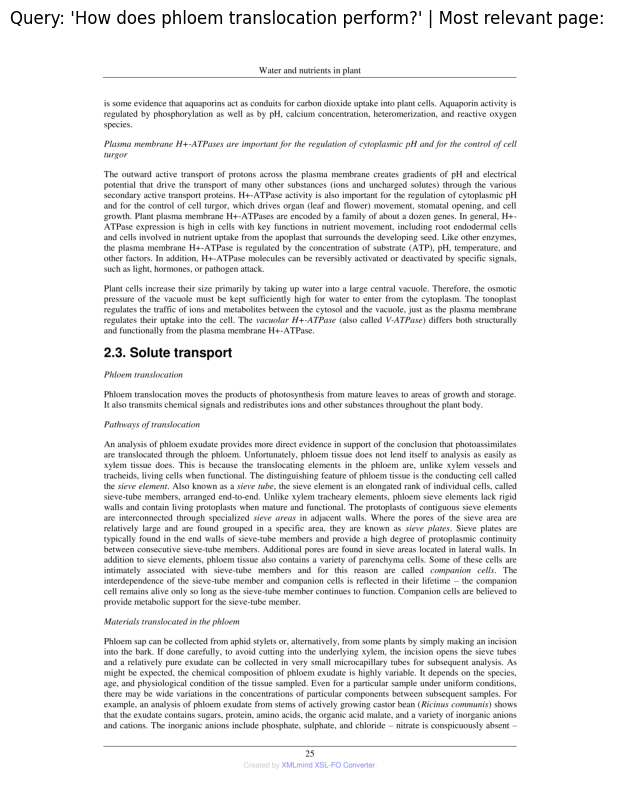

In [136]:
query = random.choice(questions)
print(f"Query: {query}")
output_text, indices = ask(query = query, temperature = 0.7, return_answer_only = False)
print_wrapped(output_text)
page_number = pages_and_groups[indices.tolist()[0]]['page_number']
print(f"Most relevant page number is : {page_number}")
get_relevant_page(pdf_path = pdf_path, query = query, index = page_number)